### Постановка задачи  

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Подключение библиотек

In [6]:
import pandas as pd
import numpy as np

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
%matplotlib inline

#### Функции

In [147]:
def draw_missing_dist(df, figsize=(14, 6), df_name=None):
    plt.figure(figsize=figsize)
    sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')
    
    title_ = f'Распределение пропусков по признакам, {df_name}' if df_name else 'Распределение пропусков по признакам'

    plt.suptitle(title_, fontsize=20)
    plt.show()

In [135]:
def target_by_featue_col(df, feature, target):
    '''
    Draws a histogram with the distribution of the target in terms of feature
    '''
    plt.figure(figsize=(10, 6))

    sns.countplot(x=feature, hue=TARGET, data=df)
    plt.title(f'{feature} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Пути к директориям и файлам**

In [9]:
TRAIN_DATASET = 'Python_libs2_course_project/course_project_train.csv'
TEST_DATASET = 'Python_libs2_course_project/course_project_test.csv'

**Загрузка данных**

In [10]:
df_train = pd.read_csv(TRAIN_DATASET)
df_test = pd.read_csv(TEST_DATASET)

### Обзор данных

In [11]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [56]:
df_train.shape

(7500, 17)

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [122]:
print(f'доля пропущенных значений в датасете:\n{(df_train.isna().sum().sum() / df_train.size).round(4)}')

доля пропущенных значений в датасете:
0.0595


Датасет содержит 17 полей, из которых 16 признаков и целевое значение.  

Категориальные и ранговые поля:  
 - Home Ownership, Bankruptcies, Purpose, Term, Years in current job, Years in current job, Number of Credit Problems, Number of Open Accounts, Months since last delinquent, Years of Credit History  

Числовые признаки:  
 - Current Loan Amount, Annual Income, Current Credit Balance, Monthly Debt, Maximum Open Credit, Tax Liens, Credit Score

Доля пропущенных значений 6%  
Судя по признаку "Current Loan Amount" датасет имеет выбросы

#### Выделение целевого значени и групп переменных

In [165]:
TARGET = 'Credit Default'
CAT_COLS = ['Home Ownership', 'Bankruptcies', 'Purpose', 'Term']
RANG_COLS = ['Years in current job', 'Number of Credit Problems', 'Number of Open Accounts',
             'Months since last delinquent', 'Years of Credit History']
NUM_COLS = ['Current Loan Amount', 'Annual Income', 'Current Credit Balance', 'Monthly Debt', 
            'Maximum Open Credit', 'Tax Liens', 'Credit Score']

#### Обзор целевой переменной

In [36]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

Наблюдается небольшой дисбаланс таргета значения распределились примерно 1 к 3. Примерно 28% положительного класса и 72% - отрицательного. Решение о балансировке будет принято далее 

#### Обзор тестового датасета

In [140]:
df_test = pd.read_csv(TEST_DATASET)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [142]:
df_test.shape

(2500, 16)

#### Сравнение пропусков в тестовом и тренировочном датасете

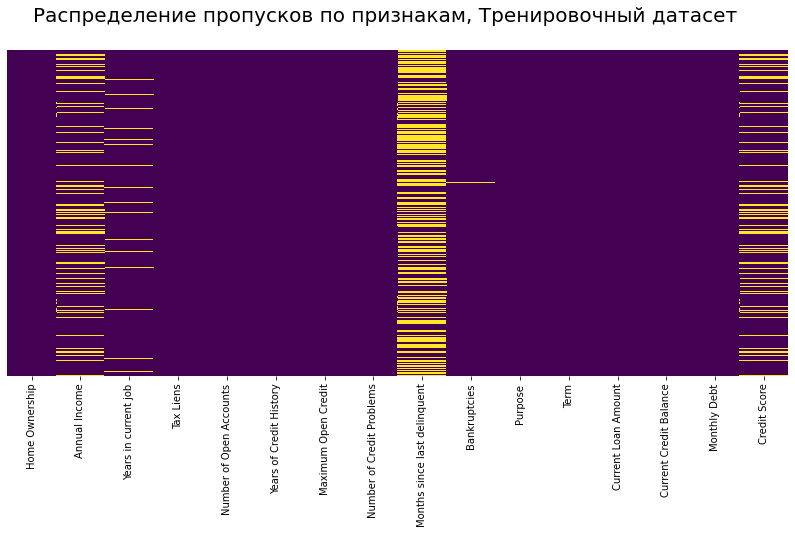

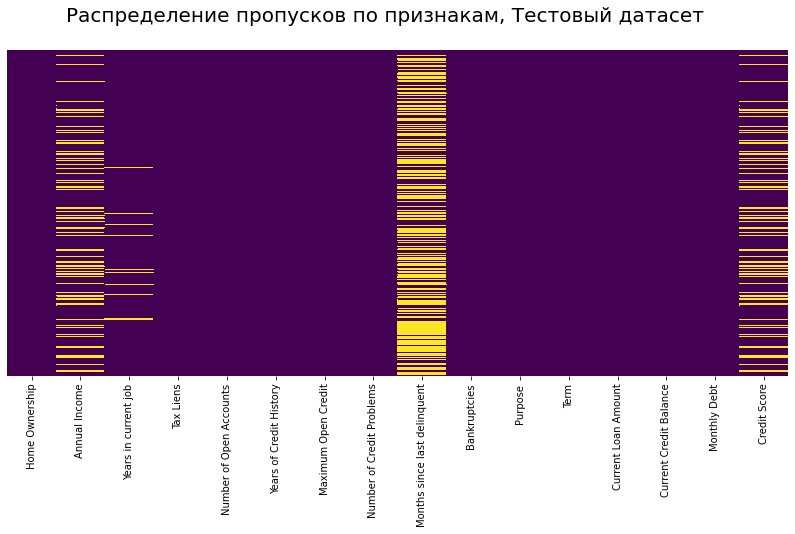

In [149]:
draw_missing_dist(df_train.drop(columns='Credit Default'), df_name='Тренировочный датасет')
draw_missing_dist(df_test, df_name='Тестовый датасет')

In [146]:
print(f'доля пропущенных значений в тестовом датасете:\n{(df_test.isna().sum().sum() / df_test.size).round(4)}')

доля пропущенных значений в тестовом датасете:
0.0618


Структура тестового и тренировочного датасетов в разрезе пропусков схожи.  
Признаки **Annual Income** и **Credit Score** имеют одинковую структуру - имеет смысл обрабатывать их в последнюю очередь, так как возможно скоринг выполнялся именно этим банком и пропуски в этом признаке обусловлены отстутствием значений в поле дохода. Таким образом можно будет попробовать восстановить сначала скоринг, а потом доход исползуя остальные признаки.  
Далле работата с восстановлением признаков и добавлением новых будет вестись на объединенном датасете 

### Объединенный датасет

In [217]:
data_concat = pd.concat([df_train, df_test]).reset_index(drop=True)
data_t = data_concat[TARGET]
data = data_concat.drop(columns=TARGET)

In [218]:
data.shape

(10000, 16)

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

### Обработка пропусков

In [220]:
print('Количество пропущенных значений в разрезе признаков')
missing_vals = data.isna().sum()
missing_vals[missing_vals > 0]

Количество пропущенных значений в разрезе признаков


Annual Income                   2070
Years in current job             457
Months since last delinquent    5439
Bankruptcies                      17
Credit Score                    2070
dtype: int64

#### Months since last delinquent
Имеет очень много пропущенных значений. Учитывая особенность признака это связано с отсутствием задержек с погашением кредита - заменяем на **0**
#### Bankruptcies
Всего 17 пропущенных значений. Предположение аналогично предыдущему - не было банкротств. Заменяем на **0**

In [221]:
data['Months since last delinquent'].fillna(0, inplace=True)
data['Bankruptcies'].fillna(0, inplace=True)

#### Years in current job

In [222]:
print(f"Доля пропусков {np.round(data['Years in current job'].isna().mean() * 100, 2)}%")

Доля пропусков 4.57%


In [223]:
print(f"Распределение значений внутри признака\n{data['Years in current job'].value_counts(normalize=True)}")

Распределение значений внутри признака
10+ years    0.329247
2 years      0.096091
3 years      0.088861
< 1 year     0.080687
5 years      0.071780
1 year       0.068846
4 years      0.065074
6 years      0.058996
7 years      0.056167
8 years      0.046736
9 years      0.037514
Name: Years in current job, dtype: float64


Судя по распределению значений данный банк достаточно консервативен в части рабочего стажа клиентов, в этом случае скорее всего произошла ошика при заполнении анкет - операционист ставил цифру больше 10(для остальных цифр есть категории), таким образом вызывая ошибку заполнения поля.  
С другой стороны, обращая внимание на значительное отличие клиентов **10+ years**(более 30%), сотрудники банка могли, в целях увеличения шансов клиентов на получение кредита, рекомендовать ставить максимальный срок работы. В этом случае отнесение пропусков в эту категорию не повлияет на итог.  
Таким образом можно поступить двумф способами - отнести пропуски к этой категории, либо исключить категорию 10+ из признаков и распеределить по оставшимся категриям.
На этом этапе - поступим первым способом - асе пропуски отнесем на **10+ years**

In [224]:
repl_map = {'10+ years': 10,
            '8 years': 8,
            '6 years': 6,
            '7 years': 7,
            '5 years': 5,
            '1 year': 1,
            '< 1 year': 0,
            '4 years': 4,
            '3 years': 3,
            '2 years': 2,
            '9 years': 9,
            np.nan: 10}

data['Years in current job'].replace(repl_map, inplace=True)

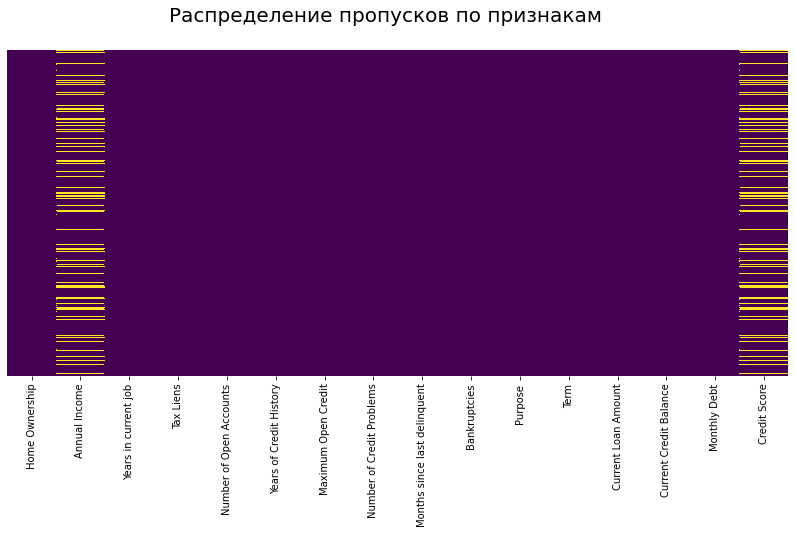

In [225]:
draw_missing_dist(data)

### Обработка выбросов

#### Категории и ранги

In [241]:
data_cat_rang = data[CAT_COLS + RANG_COLS]

for col in data_cat_rang.columns:
    unique_vol = data_cat_rang[col].nunique()
    if unique_vol <= 20:
        print(f'{col}, unique = {unique_vol}:\n{"-" * 50}\n{data_cat_rang[col].value_counts()}\n{"*" * 100}\n')
    else:
        print(f'{col}, unique = {unique_vol}\n{"*" * 100}\n')

Home Ownership, unique = 4:
--------------------------------------------------
Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64
****************************************************************************************************

Bankruptcies, unique = 6:
--------------------------------------------------
0.0    8929
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64
****************************************************************************************************

Purpose, unique = 15:
--------------------------------------------------
debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses

#### Home Ownership
Home Mortgage и Have Mortgage вероятнее всего одно и то же. Объединяем

In [259]:
data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [261]:
data['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent'], dtype=object)

#### Bankruptcies
Исходя из относительной молодости закона о банкротсве, оно может либо быть, либо нет. Таким образом, учитывая малую долю банкротств превышающих 1(всего 51 случай), объединяем все что не равно 0 в 1 класс.

In [256]:
data.loc[data['Bankruptcies'] != 0, 'Bankruptcies'] = 1

#### Term
Оставляем

#### Years in current job
На данный момент 10 - это мусорный класс, остальные распределены более-менее нормально.

#### Number of Credit Problems
Признак влияет на цевую переменную до 5 проблем. классы 6, 7 и выше должны так же показывать наличие проблем с погашением кредита, однако имеют только один целевой класс. В данном случае целесообразно отнести все классы больше 5 на 0.

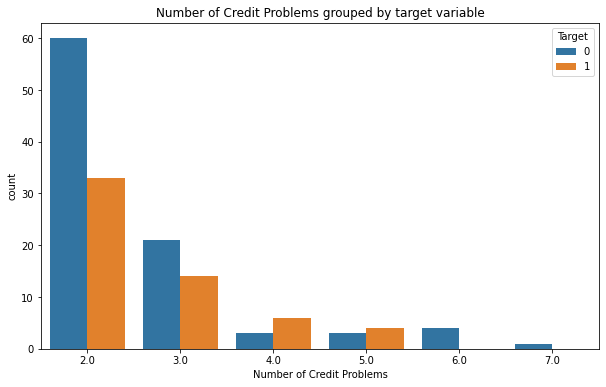

In [253]:
target_by_featue_col(df_train[df_train['Number of Credit Problems'] > 1], 'Number of Credit Problems', TARGET)

In [257]:
data.loc[data['Number of Credit Problems'] > 5, 'Number of Credit Problems'] = 0

#### Purpose
renewable energy переносим на other  
vacation - на take a trip
moving - на home improvements

In [265]:
data.loc[data['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
data.loc[data['Purpose'] == 'vacation', 'Purpose'] = 'take a trip'
data.loc[data['Purpose'] == 'moving', 'Purpose'] = 'home improvements'

In [266]:
data_cat_rang = data[CAT_COLS + RANG_COLS]
for col in data_cat_rang.columns:
    unique_vol = data_cat_rang[col].nunique()
    if unique_vol <= 20:
        print(f'{col}, unique = {unique_vol}:\n{"-" * 50}\n{data_cat_rang[col].value_counts()}\n{"*" * 100}\n')
    else:
        print(f'{col}, unique = {unique_vol}\n{"*" * 100}\n')

Home Ownership, unique = 3:
--------------------------------------------------
Home Mortgage    4881
Rent             4224
Own Home          895
Name: Home Ownership, dtype: int64
****************************************************************************************************

Bankruptcies, unique = 2:
--------------------------------------------------
0.0    8929
1.0    1071
Name: Bankruptcies, dtype: int64
****************************************************************************************************

Purpose, unique = 12:
--------------------------------------------------
debt consolidation      7917
other                    907
home improvements        564
business loan            159
buy a car                130
medical bills             98
take a trip               62
buy house                 53
major purchase            49
small business            31
wedding                   17
educational expenses      13
Name: Purpose, dtype: int64
*********************************

### Поключение библиотек

In [1]:
import pandas as pd
import numpy as np
import catboost as catb
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline